# 🤖 Train ElasticNet on Drug Response with scFoundation Embeddings

In this notebook, we train an ElasticNet regression model for each drug using scFoundation-derived PCA features, and evaluate performance using cross-validation.


In [1]:
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns


## 📥 Configuration and Dataset Loading


In [2]:
# Set number of components you want to test
NUM_PCS = 30  # ← update this based on your PCA choice

DATA_PATH = f"../../data/bulk/bulk_with_scfoundation_pca_top{NUM_PCS}.parquet"
data = pd.read_parquet(DATA_PATH)

print("✅ Dataset loaded:", data.shape)


✅ Dataset loaded: (571985, 53)


In [3]:
# Prepare columns
os.makedirs("results/elastic_net", exist_ok=True)

non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]

# CV setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)


## 🔁 Train ElasticNetCV per Drug with Cross-Validation


In [4]:
results = []

for drug_id in sorted(data["DRUG_ID"].unique()):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 10:
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    model = ElasticNetCV(
        alphas=[0.01, 0.1, 1.0, 10.0],
        l1_ratio=[0.1, 0.5, 0.9],
        cv=kf,
        max_iter=5000,
        random_state=42
    )
    model.fit(X, y)

    rmse_scores = cross_val_score(model, X, y, scoring=rmse_scorer, cv=kf)
    r2_scores = cross_val_score(model, X, y, scoring="r2", cv=kf)

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "alpha": model.alpha_,
        "l1_ratio": model.l1_ratio_,
        "rmse_mean": -rmse_scores.mean(),
        "rmse_std": rmse_scores.std(),
        "r2_mean": r2_scores.mean(),
        "r2_std": r2_scores.std()
    })


## 💾 Save and Preview Results


In [5]:
results_df = pd.DataFrame(results)
results_df.to_csv(f"results/elastic_net/elastic_net_results_{NUM_PCS}_pcs.csv", index=False)

print(f"📁 Saved to results/elastic_net/elastic_net_results_{NUM_PCS}_pcs.csv")
results_df.head()


📁 Saved to results/elastic_net/elastic_net_results_30_pcs.csv


,DRUG_ID,n_samples,alpha,l1_ratio,rmse_mean,rmse_std,r2_mean,r2_std
0,1,391,0.1,0.1,1.082200,0.207319,0.033581,0.088417
1,3,356,10.0,0.1,1.926915,0.197064,0.058313,0.015790
2,5,394,10.0,0.1,1.485117,0.105026,0.186374,0.048068
3,6,403,1.0,0.5,0.884720,0.104189,0.002488,0.065188
4,9,396,10.0,0.1,1.416961,0.134206,0.047869,0.072439


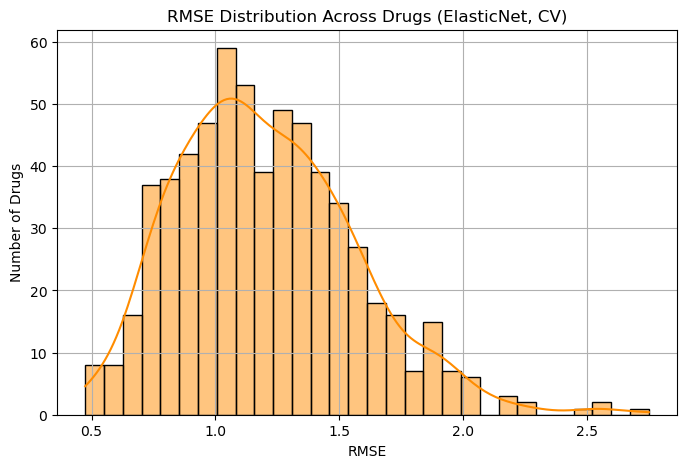

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse_mean"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (ElasticNet, CV)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/elastic_net/elastic_net_rmse_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()


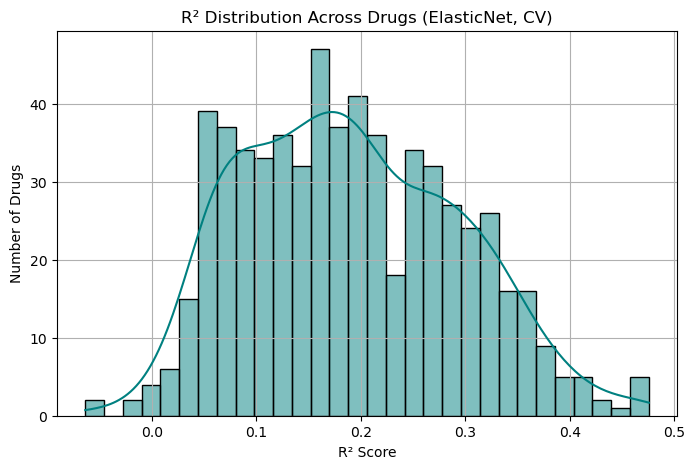

In [7]:
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_mean"], kde=True, bins=30, color="teal")
plt.title("R² Distribution Across Drugs (ElasticNet, CV)")
plt.xlabel("R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.savefig(f"results/elastic_net/elastic_net_r2_{NUM_PCS}_pcs.png", dpi=300)
plt.show()
plt.close()
